In [ ]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

dataset = pd.read_excel('/content/SIHJudge1.xlsx', header=0, index_col=0)
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, n_in=1, n_out=1)

n_features = dataset.shape[1]

reframed.drop(reframed.columns[range(n_features, n_features * 2 - 1)], axis=1, inplace=True)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.047842    0.56674   0.157216   0.171679   0.152861   0.232585   
2   0.025923    0.56674   0.316067   0.171679   0.152007   0.232585   
3   0.007009    0.56674   0.339513   0.171679   0.152434   0.232585   
4   0.000000    0.56674   0.409306   0.171679   0.153715   0.232585   
5   0.029261    0.56674   0.347692   0.171679   0.151153   0.232585   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var10(t)  
1        0.0        0.0   0.179949    0.046028  0.089295  
2        0.0        0.0   0.349100    0.089295  0.091662  
3        0.0        0.0   0.358355    0.091662  0.044845  
4        0.0        0.0   0.175321    0.044845  0.002367  
5        0.0        0.0   0.009254    0.002367  0.222514  


In [ ]:
values = reframed.values

n_train_months = 69

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(f"Train X shape: {train_X.shape}, Train y shape: {train_y.shape}")
print(f"Test X shape: {test_X.shape}, Test y shape: {test_y.shape}")


Train X shape: (69, 1, 10), Train y shape: (69,)
Test X shape: (28, 1, 10), Test y shape: (28,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 2s - 2s/step - loss: 0.2490 - val_loss: 0.3165
Epoch 2/50
1/1 - 0s - 52ms/step - loss: 0.2408 - val_loss: 0.3050
Epoch 3/50
1/1 - 0s - 61ms/step - loss: 0.2326 - val_loss: 0.2936
Epoch 4/50
1/1 - 0s - 132ms/step - loss: 0.2245 - val_loss: 0.2821
Epoch 5/50
1/1 - 0s - 60ms/step - loss: 0.2165 - val_loss: 0.2706
Epoch 6/50
1/1 - 0s - 64ms/step - loss: 0.2090 - val_loss: 0.2592
Epoch 7/50
1/1 - 0s - 130ms/step - loss: 0.2018 - val_loss: 0.2478
Epoch 8/50
1/1 - 0s - 59ms/step - loss: 0.1953 - val_loss: 0.2371
Epoch 9/50
1/1 - 0s - 61ms/step - loss: 0.1893 - val_loss: 0.2268
Epoch 10/50
1/1 - 0s - 52ms/step - loss: 0.1836 - val_loss: 0.2168
Epoch 11/50
1/1 - 0s - 59ms/step - loss: 0.1782 - val_loss: 0.2069
Epoch 12/50
1/1 - 0s - 61ms/step - loss: 0.1739 - val_loss: 0.1972
Epoch 13/50
1/1 - 0s - 64ms/step - loss: 0.1703 - val_loss: 0.1878
Epoch 14/50
1/1 - 0s - 56ms/step - loss: 0.1678 - val_loss: 0.1789
Epoch 15/50
1/1 - 0s - 51ms/step - loss: 0.1659 - val_loss: 0.1704
Epoch 16/50
1/1

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Test RMSE: 16.170


In [ ]:
def forecast_next_steps(model, last_obs, scaler, steps=1):
    forecasts = []
    current_input = last_obs

    for _ in range(steps):
        yhat = model.predict(current_input, verbose=0)

        forecasts.append(yhat[0, 0])

        current_input = np.concatenate((current_input[:, :, 1:], yhat[:, np.newaxis, :]), axis=2)

    forecasts = np.array(forecasts).reshape(-1, 1)
    forecasts_scaled = np.concatenate((np.zeros((forecasts.shape[0], scaler.n_features_in_ - 1)), forecasts), axis=1)
    forecasts = scaler.inverse_transform(forecasts_scaled)[:, -1]

    return forecasts


In [ ]:
if len(test_X.shape) == 2:
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print("Reshaped test_X to 3D:", test_X.shape)

last_obs = test_X[-1]
last_obs = last_obs.reshape((1, test_X.shape[1], test_X.shape[2]))
print("Last observation shape:", last_obs.shape)

next_steps = forecast_next_steps(model, last_obs, scaler, steps=23)
print(f"Forecasted values for the next steps: {next_steps}")

Last observation shape: (1, 1, 10)
Forecasted values for the next steps: [17.9968365  18.23042183 19.31924331 15.65639424 16.44918386 17.94253457
 17.26028979 14.92947308 18.83224142 17.75036121 16.02463531 15.75689315
 16.14712738 15.34151352 15.40705338 15.58818597 15.26989126 14.87615467
 15.26775653 14.98839686 14.59097321 14.47055128 14.47196537]


In [ ]:
saved_model_path = r"SIHJudge1.keras"
model.save(saved_model_path)

In [ ]:
data=pd.read_csv('/content/Water Audit final 100 years data.csv')
target=data['Target']

In [ ]:
tar=target[98:]
tar

,Target
98,23.14
99,13.60
100,5.76
101,12.04
102,13.63
103,39.64
104,46.40
105,33.33
106,25.31
107,38.15


In [ ]:
err=(tar-next_steps)/tar
err

,Target
98,0.222263
99,-0.340472
100,-2.354035
101,-0.300365
102,-0.206837
103,0.547363
104,0.628011
105,0.552071
106,0.255937
107,0.534722


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plt.scatter(np.arange(1,24),err)
#plt.xlabel('Months')
#plt.ylabel('Error')
#plt.title('Error Rate')
#plt.show()

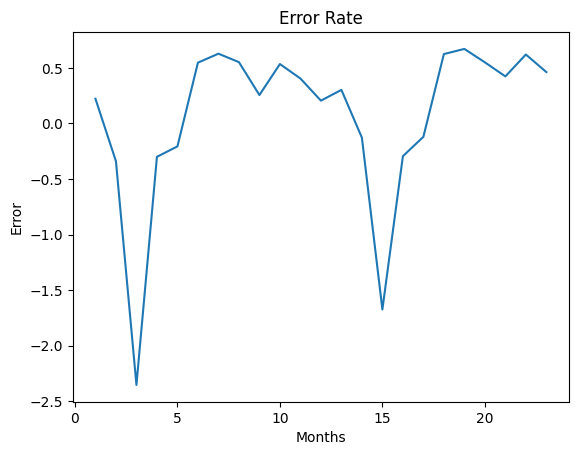

In [ ]:
plt.plot(np.arange(1,24),err)
plt.xlabel('Months')
plt.ylabel('Error')
plt.title('Error Rate')
plt.show()

In [ ]:
errp=err*100
round(errp.mean(),2)

6.89

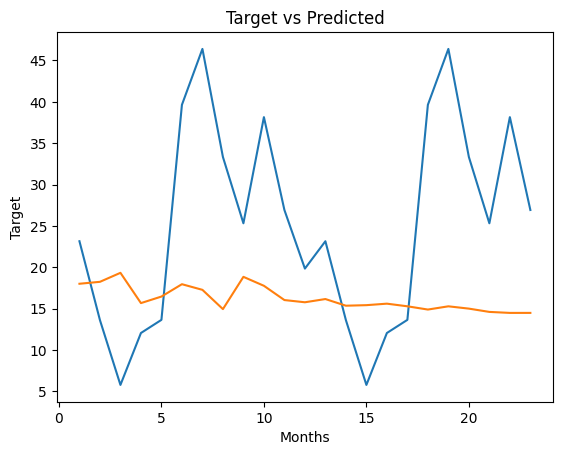

In [ ]:
plt.plot(np.arange(1,24),tar)
plt.plot(np.arange(1,24),next_steps)
plt.xlabel('Months')
plt.ylabel('Target')
plt.title('Target vs Predicted')
plt.show()